# Convolution Neural Networks - Multi-Classifier and Transfer Learning

## Written by: Rodrigo Escandon
### Transfer Learning Model: InceptionResNetV2

# Executive Summary

A Convolutional Neural Network was developed to predict images (current and future) from three types of classes (Black Bear, Grizzly Bear and Teddy Bear). This predictive model used three hundred images from three respective categories for training and testing. To increase model performance a transfer learning model was downloaded and incorporated with the existing model's architecture.

## Model Performance

The accuracy in the model for the testing set was calculated at 93.3%. The model was effectively able to predict all three categories, only mistaking four out of the sixty evaluated images.

In [1]:
#Importing the Keras libraries and packages. 
#Keras will be using TensorFlow as a backend.
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import tqdm
import os
from multiprocessing.pool import ThreadPool
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

tf=1.5.0

keras=2.1.4

In [2]:
print(tf.__version__,"Tensorflow")
print(keras.__version__,"Keras")
print(cv2.__version__,"OpenCV")
print(np.__version__,"Numpy")

2.10.0 Tensorflow
2.10.0 Keras
4.7.0 OpenCV
1.21.5 Numpy


In [3]:
#Target and batch sizes
bs=32
ts=128

In [4]:
#Display label data as 'fname' and 'label'
path='C://Users//####//Desktop//Computer_Vision//'
df_data=pd.read_csv(path+'bears_data.csv')

In [5]:
df_data

fname  label
0    C://Users//Sarah//Desktop//Computer_Vision//be...  black
1    C://Users//Sarah//Desktop//Computer_Vision//be...  black
2    C://Users//Sarah//Desktop//Computer_Vision//be...  black
3    C://Users//Sarah//Desktop//Computer_Vision//be...  black
4    C://Users//Sarah//Desktop//Computer_Vision//be...  black
..                                                 ...    ...
295  C://Users//Sarah//Desktop//Computer_Vision//be...  teddy
296  C://Users//Sarah//Desktop//Computer_Vision//be...  teddy
297  C://Users//Sarah//Desktop//Computer_Vision//be...  teddy
298  C://Users//Sarah//Desktop//Computer_Vision//be...  teddy
299  C://Users//Sarah//Desktop//Computer_Vision//be...  teddy

[300 rows x 2 columns]

In [6]:
#Shufflling the data
df_data_shuffle=df_data.sample(frac=1).reset_index(drop=True)

Text(0, 0.5, 'Class Sample Count')

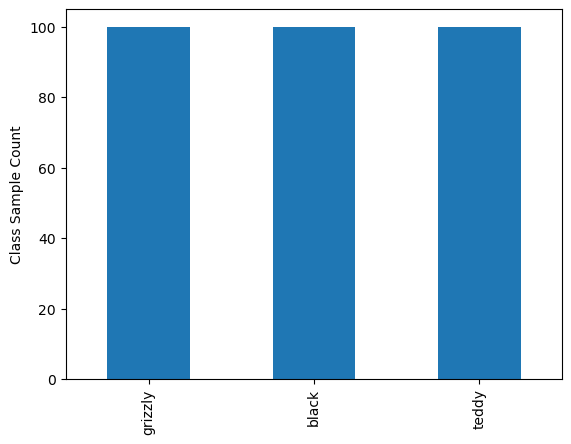

In [7]:
#Display counts from shuffle data for all different labels
df_data_shuffle.label.value_counts(sort=False,normalize=False).sort_values().plot.bar()
plt.ylabel('Class Sample Count')

In [8]:
#Split data into train & validation. Maintaining label ratios.
x_train, x_valid, y_train, y_valid=train_test_split(df_data['fname'],df_data['label'],test_size=0.2,random_state=1234)
df_train=pd.concat([x_train,y_train],axis=1).reset_index(drop=True)
df_valid=pd.concat([x_valid,y_valid],axis=1).reset_index(drop=True)

black      82
teddy      81
grizzly    77
Name: label, dtype: int64

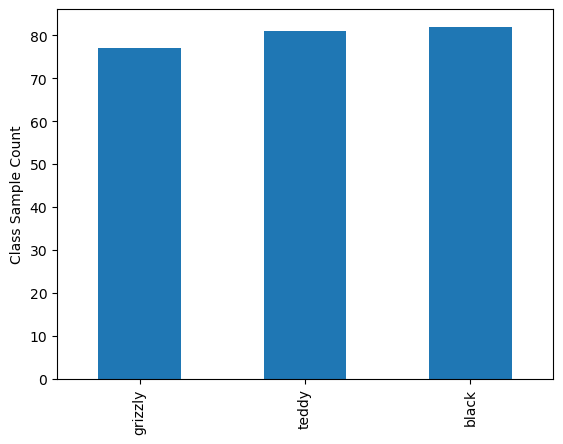

In [9]:
#Display counts from train data for all different labels
df_train.label.value_counts(sort=False,normalize=False).sort_values().plot.bar()
plt.ylabel('Class Sample Count')
pd.value_counts(y_train)

grizzly    23
teddy      19
black      18
Name: label, dtype: int64

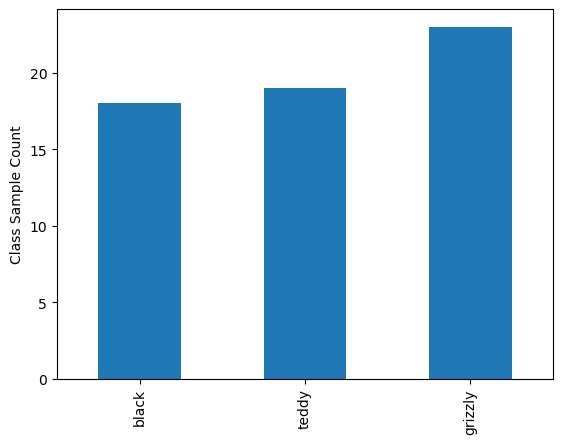

In [10]:
#Display counts from validation data for all different labels
#Display counts from train data for all different labels
df_valid.label.value_counts(sort=False,normalize=False).sort_values().plot.bar()
plt.ylabel('Class Sample Count')
pd.value_counts(y_valid)

In [11]:
#CV Transfer Model Download and Condition
transfer_model=tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(ts,ts,3))
transfer_model.trainable=False

In [12]:
#Creation of Model Architecture
do=0.1 #Dropout percentage
classifier=tf.keras.Sequential([transfer_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.BatchNormalization(),
                          #tf.keras.layers.Dense(64,activation='relu'),
                          #tf.keras.layers.Dropout(do),
                          tf.keras.layers.Dense(64,activation='relu'),
                          tf.keras.layers.Dropout(do),
                          tf.keras.layers.Dense(64,activation='relu'),
                          tf.keras.layers.Dropout(do),
                          tf.keras.layers.Dense(3,activation='softmax')])

In [13]:
#Compiling the CNN
#The descent and loss conditions will be added. 
#In this case it will be Stochastic Gradient descent and Logarithmic Loss.
lr=0.001
optim=tf.keras.optimizers.Adam(lr)
classifier.compile(optimizer=optim,loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
#Image augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
#These sets will create the training set and test set
train_set = train_datagen.flow_from_dataframe(df_train,directory=path,
                                              x_col='fname',
                                              y_col='label',
                                              color_mode='rgb',
                                              shuffle=True,
                                              target_size=(ts, ts),
                                              batch_size=bs,
                                              class_mode='categorical',seed=1234)

Found 240 validated image filenames belonging to 3 classes.


In [17]:
test_set = test_datagen.flow_from_dataframe(df_valid,directory=path,
                                            x_col='fname',
                                            y_col='label',
                                            color_mode='rgb',
                                            shuffle=True,
                                            target_size=(ts, ts),
                                            batch_size=bs,
                                            class_mode='categorical',seed=1234)

Found 60 validated image filenames belonging to 3 classes.


In [18]:
#Verify batch size and image conditions
x,y=next(train_set)
x.shape

(32, 128, 128, 3)

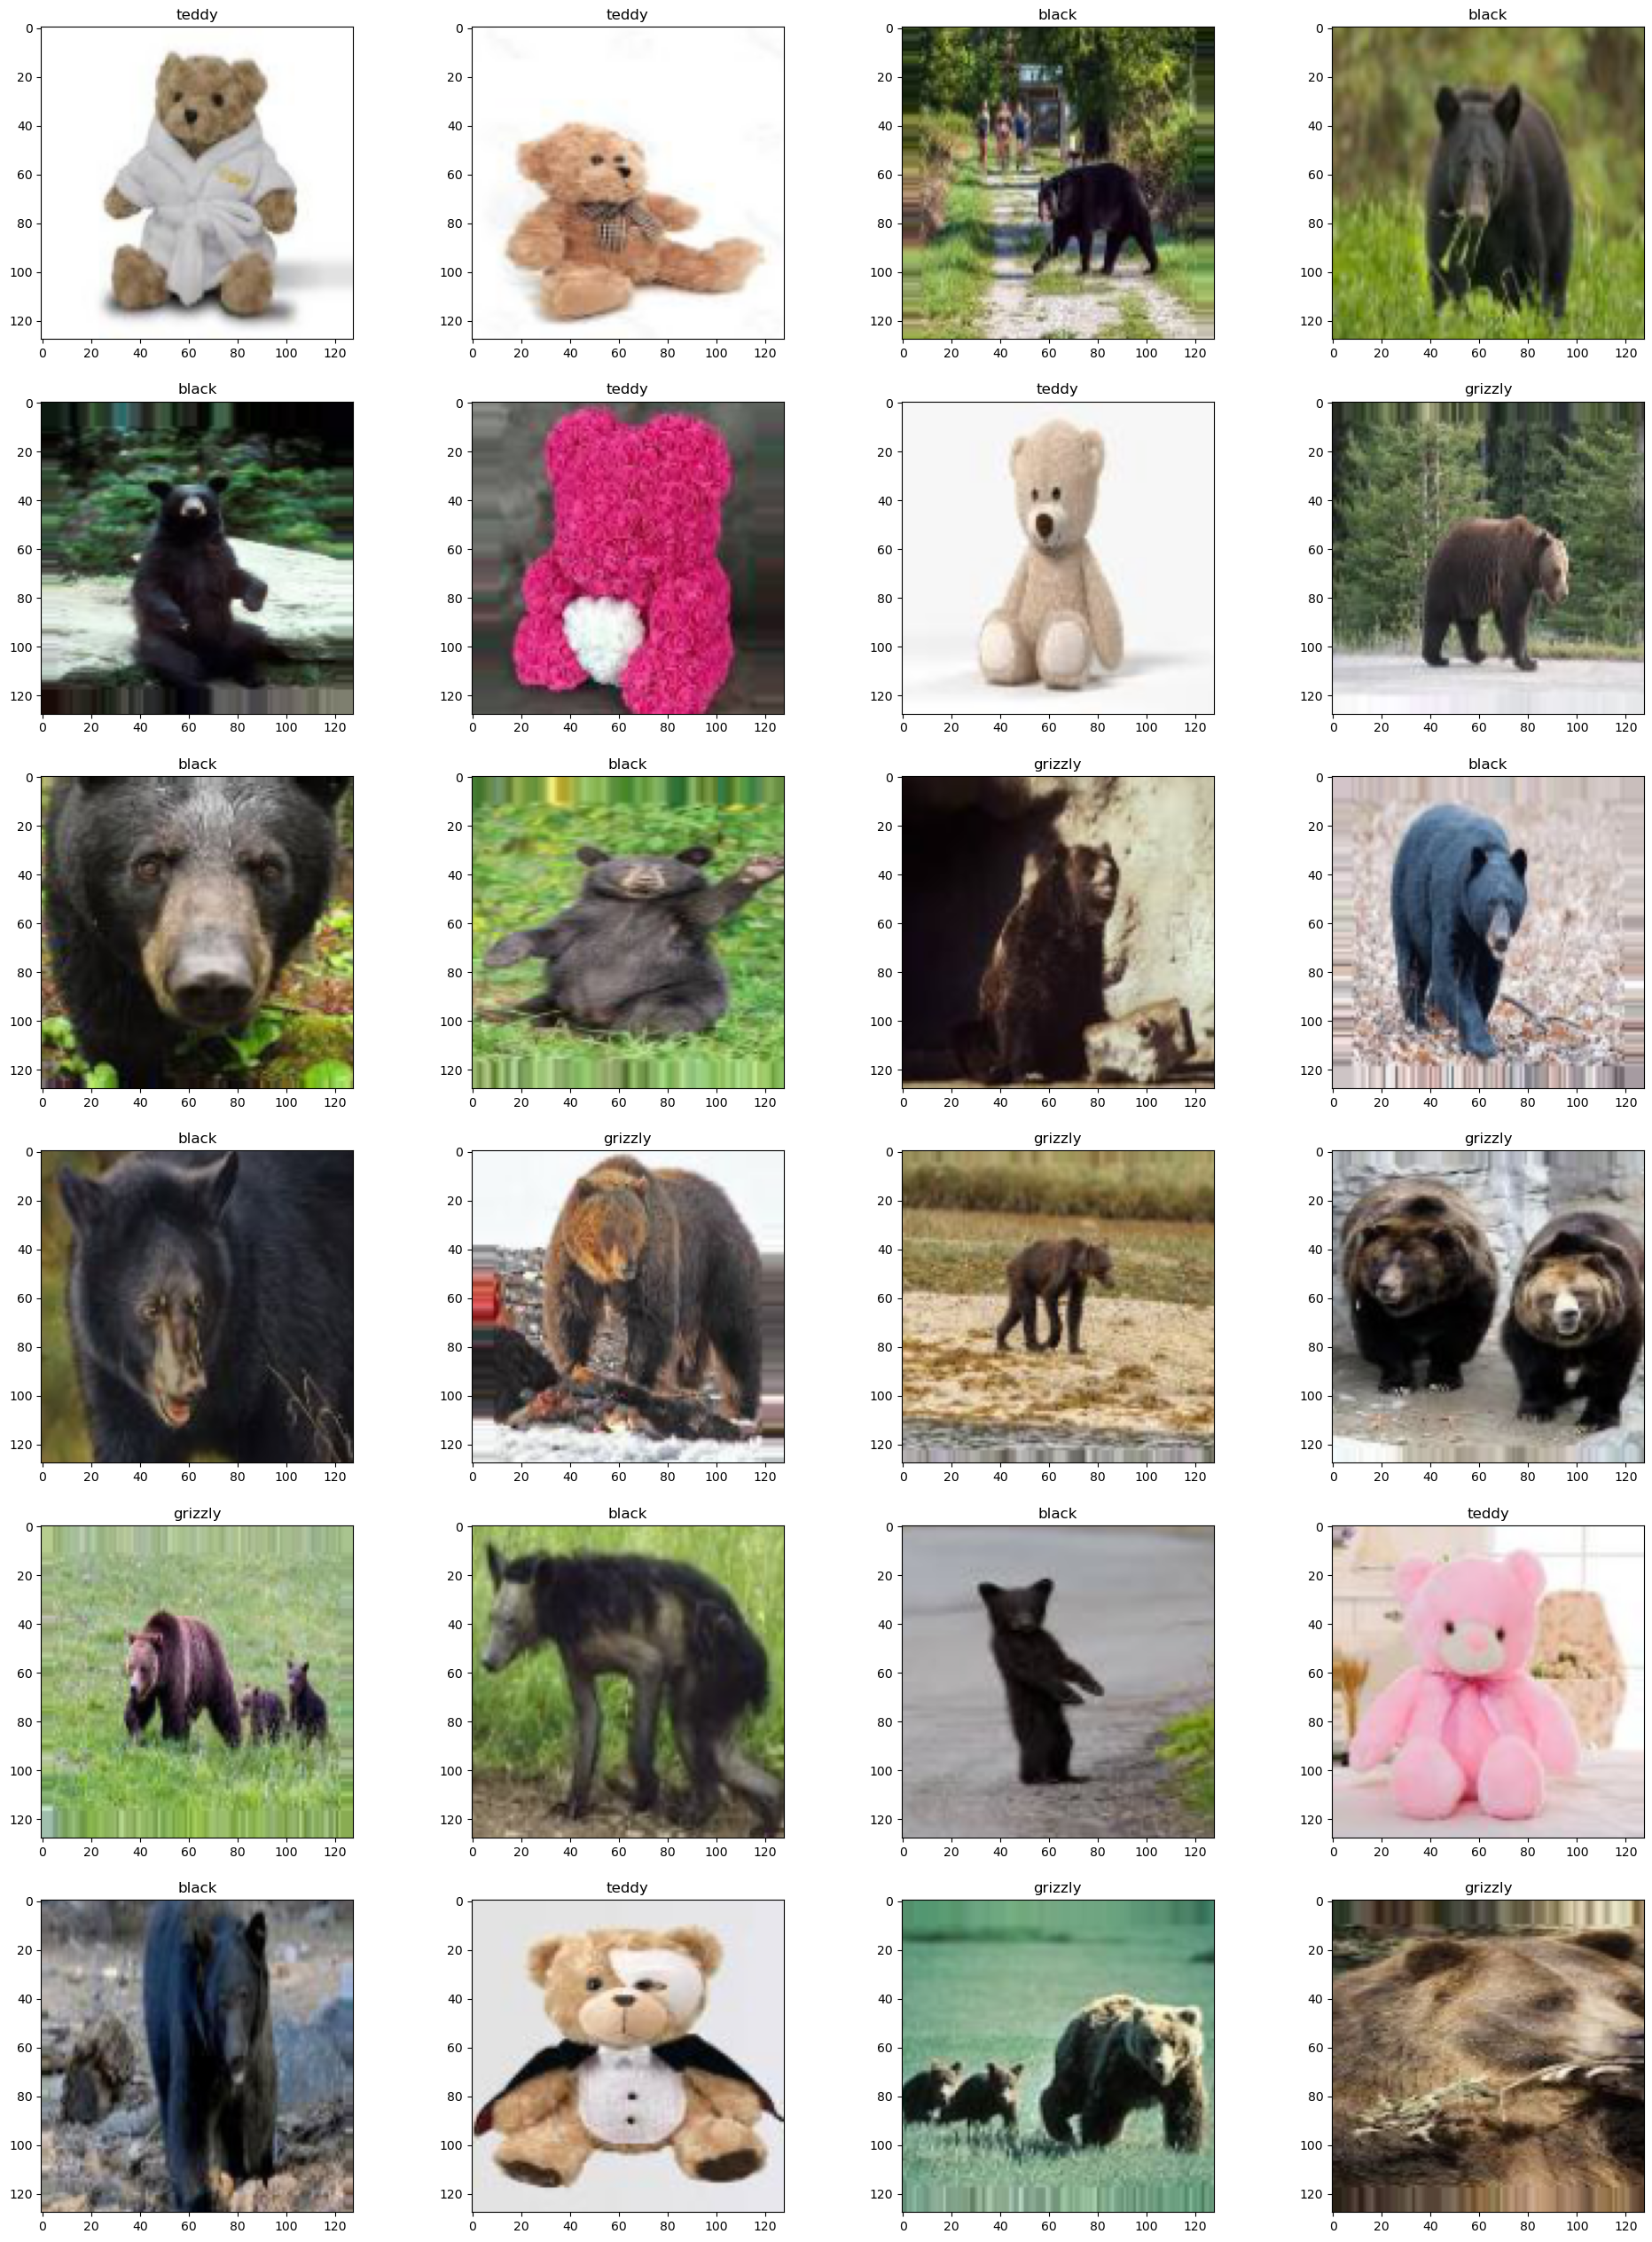

In [19]:
#Randomly visualizing an image from the training set
a=train_set.class_indices
classes=list(a.keys())
x,y=next(train_set)
plt.figure(figsize=[24,32])
for i in range(0,24):
    plt.subplot(6,4,i+1)
    plt.imshow(x[i])
    #plt.title(classes[int(y[i])]) #Binary Classifier
    plt.title(classes[np.argmax(y[i])]) #Multi Classifier

In [20]:
ss_train=train_set.n//train_set.batch_size
ss_test=test_set.n//test_set.batch_size
#call=tf.keras.callbacks.ModelCheckpoint('./CNN_Transfer_Model.hdf5',save_best_only=True,save_weights_only=False,mode='min')
#call=tf.keras.callbacks.EarlyStopping(patience=15,min_delta=0.001,mode='min',restore_best_weights=True)
call=EarlyStopping(patience=2,monitor='val_loss', mode='min', verbose=1,restore_best_weights=True)

In [21]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [22]:
#This generator will fit the CNN on the training set and evaluate its performance in the test set
#Without doing a optimization analysis of the code the accuracy from the training set is 0.9279 and test set 0.9688
classifier.fit(train_set,
                steps_per_epoch=ss_train,
                epochs=18,
                validation_data=test_set,
                validation_steps=ss_test,
                callbacks=[call])

Epoch 1/18
7/7 [==============================] - 28s 2s/step - loss: 0.5026 - accuracy: 0.7837 - val_loss: 0.3762 - val_accuracy: 0.9062
Epoch 2/18
7/7 [==============================] - 13s 2s/step - loss: 0.1667 - accuracy: 0.9279 - val_loss: 0.1059 - val_accuracy: 0.9688
Epoch 3/18
7/7 [==============================] - 12s 2s/step - loss: 0.1636 - accuracy: 0.9471 - val_loss: 0.6645 - val_accuracy: 0.8125
Epoch 4/18
7/7 [==============================] - 12s 2s/step - loss: 0.1980 - accuracy: 0.9327 - val_loss: 0.1299 - val_accuracy: 0.9062
Epoch 4: early stopping


In [30]:
#Keeps the batch normalization layers on, makes other layers trainable in transfer model
for layer in transfer_model.layers[:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        transfer_model.trainable=True

In [31]:
#Model re-compiling adding transfer model as trainable and reducing learning rate
lr=0.0001
optim=tf.keras.optimizers.Adam(lr)
classifier.compile(optimizer=optim,loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
#Summary of Model Architecture
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [33]:
#Fitting of re-compiled model
classifier.fit(train_set,
                steps_per_epoch=ss_train,
                epochs=8,
                validation_data=test_set,
                validation_steps=ss_test,
                callbacks=[call])

Epoch 1/8
7/7 [==============================] - 83s 9s/step - loss: 0.6550 - accuracy: 0.6683 - val_loss: 0.2700 - val_accuracy: 0.9375
Epoch 2/8
7/7 [==============================] - 57s 8s/step - loss: 0.3736 - accuracy: 0.8510 - val_loss: 0.1148 - val_accuracy: 1.0000
Epoch 3/8
7/7 [==============================] - 56s 8s/step - loss: 0.2386 - accuracy: 0.9423 - val_loss: 0.3367 - val_accuracy: 0.9062
Epoch 4/8
7/7 [==============================] - 58s 8s/step - loss: 0.1753 - accuracy: 0.9663 - val_loss: 0.2081 - val_accuracy: 0.9375
Epoch 4: early stopping


In [34]:
classifier.evaluate(test_set)

2/2 [==============================] - 3s 1s/step - loss: 0.2267 - accuracy: 0.9333


[0.22671617567539215, 0.9333333373069763]

In [35]:
train_set.class_indices

{'black': 0, 'grizzly': 1, 'teddy': 2}

In [36]:
def eval_pred(args):
    classes=[0,1,2]
    image_path,resy=args
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=image/255 #Only use if re-scaling
    image=cv2.resize(image,[ts,ts])
    image=np.expand_dims(image,axis=0)
    res=classifier.predict(image)
    res_x=classes[np.argmax(res)]
    res_y=int(np.where(resy=='black',0,np.where(resy=='grizzly',1,2)))
    return res_x,res_y

In [37]:
%%time
pool=ThreadPool(processes=4)
res=pool.map(eval_pred,df_valid.values)

1/1 [==============================] - 0s 166ms/step
Wall time: 15 s


In [38]:
res=pd.DataFrame(res,columns=['prediction','actual'])

Text(0.5, 1.0, 'Confusion Matrix Test')

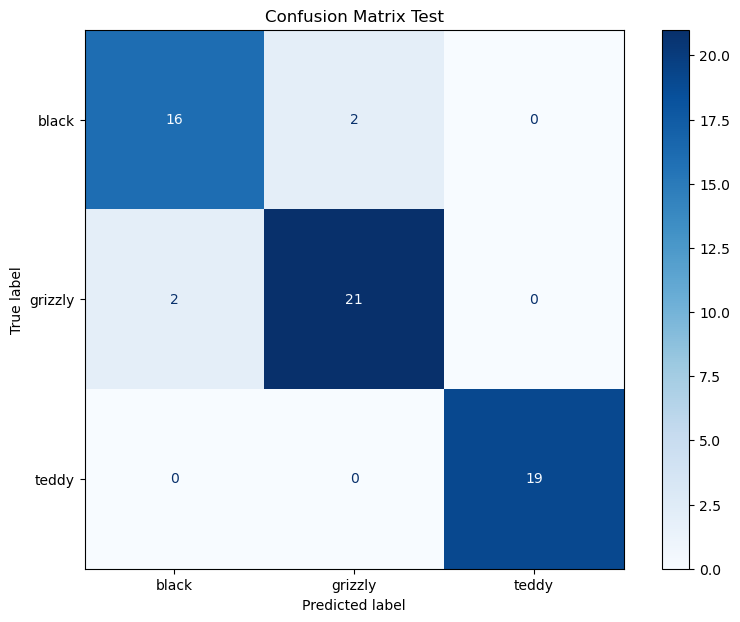

In [39]:
#Displaying confusion matrix of the validation data
plt.rcParams['figure.figsize']=[10,7]
a=train_set.class_indices
cm=confusion_matrix(np.array(res['prediction']),np.array(res['actual']))
CMD=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=a)
CMD.plot(cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix Test')

In [40]:
#Running classification report
print(classification_report(np.array(res['prediction']),np.array(res['actual']),target_names=a))

              precision    recall  f1-score   support

       black       0.89      0.89      0.89        18
     grizzly       0.91      0.91      0.91        23
       teddy       1.00      1.00      1.00        19

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60

